In [1]:
from umap import UMAP
import umap.plot

import numpy as np
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

In [2]:
!git lfs install
!git clone https://huggingface.co/datasets/cat-state/clip-embeddings || true
prefix = !readlink -f clip-embeddings

Updated Git hooks.
Git LFS initialized.
fatal: destination path 'clip-embeddings' already exists and is not an empty directory.


In [3]:
!cd clip-embeddings && git lfs pull

In [2]:
models = {
    'openclip ViT-B-16': dict(img_embeds=np.load('clip-embeddings/coco-embeds-open-clip-vit-b-16/img_emb/img_emb_0.npy'),
                              text_embeds=np.load('clip-embeddings/coco-embeds-open-clip-vit-b-16/text_emb/text_emb_0.npy')),
    'cloob ViT-B-16': dict(img_embeds=np.load('clip-embeddings/cloob-vit-b-16/cloob_laion_400m_vit_b_16_32_epochs_coco_train2017_image_embeds.npy'),
                           text_embeds=np.load('clip-embeddings/cloob-vit-b-16/cloob_laion_400m_vit_b_16_32_epochs_coco_train2017_text_embeds.npy')),
    
    'ml_jku_cloob_infoNCE': dict(img_embeds=np.load("clip-embeddings/ml_jku_cloob_embeddings/cloob_infoNCE_rn50_cc_epoch_128_image_embeds.npy"),
                            text_embeds=np.load("clip-embeddings/ml_jku_cloob_embeddings/cloob_infoNCE_rn50_cc_epoch_128_text_embeds.npy")),

    'ml_jku_clip_rn50': dict(img_embeds=np.load("clip-embeddings/ml_jku_cloob_embeddings/clip30_rn50_cc_epoch_128_image_embeds.npy"),
                        text_embeds=np.load("clip-embeddings/ml_jku_cloob_embeddings/clip30_rn50_cc_epoch_128_text_embeds.npy")),

    'ml_jku_clip_infoLOOB': dict(img_embeds=np.load("clip-embeddings/ml_jku_cloob_embeddings/clip_infoLOOB_rn50_cc_epoch_128_image_embeds.npy"),
                            text_embeds=np.load("clip-embeddings/ml_jku_cloob_embeddings/clip_infoLOOB_rn50_cc_epoch_128_text_embeds.npy")),

    'ml_jku_cloob_rn50': dict(img_embeds=np.load("clip-embeddings/ml_jku_cloob_embeddings/cloob_rn50_cc_epoch_128_image_embeds.npy"),
                         text_embeds=np.load("clip-embeddings/ml_jku_cloob_embeddings/cloob_rn50_cc_epoch_128_text_embeds.npy")),

}

In [5]:
!mkdir -p figures

In [3]:
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [6]:
from umap import UMAP
from umap.umap_ import nearest_neighbors
from functools import cache

@cache
def cached_neighbors(name, n):
    img_embeds, text_embeds = models[name]['img_embeds'][:n], models[name]['text_embeds'][:n]

    data = np.concatenate([img_embeds, text_embeds], axis=0)
    knn = nearest_neighbors(data, n_neighbors=250,
                                  metric="cosine",
                                  metric_kwds=None,
                                  angular=True,
                                  random_state=None,
                                 )
    return data, knn

@cache
def cached_umap(name, n = 5000, k = 15, min_dist = 0.1):
    data, knn = cached_neighbors(name, n)
    return UMAP(n_neighbors=k, min_dist=min_dist, precomputed_knn=knn).fit(data)
    

In [8]:


def plot_comparisons(keys, n=5000):
    
    idents = [ident for _, ident in keys]
    
    fig, axes = plt.subplots(1, len(keys), figsize=(10 * len(keys), 10), facecolor='white', squeeze=False)

    for ax, (name, data_key) in zip(axes[0], keys):
        umaped = cached_umap(data_key, n)
        imgs_umap, txt_umap = umaped.embedding_[:n], umaped.embedding_[n:]

        if n < 10000:
            for (x0, y0, x1, y1) in zip(imgs_umap[:, 0], imgs_umap[:, 1],
                                        txt_umap[:, 0], txt_umap[:, 1]):
                ax.plot((x0, x1), (y0, y1), "k-", alpha=0.05, #c=(x0 * 0.1 % 1, y0 * 0.1 % 1, y1 * 0.1 % 1, (x1 % 0.9) + 0.1), 
                         zorder=1)

        ax.scatter(*imgs_umap.T, label="imgs", s=0.3, zorder=2)
        ax.scatter(*txt_umap.T, label="txt", s=0.3, zorder=2)

        ax.set(title=name, xticks=[], yticks=[])
        ax.legend(markerscale=10)
        
    plt.savefig(f"figures/UMAP_lines_{'_vs_'.join(idents)}.png")
    plt.show()

    fig, axes = plt.subplots(1, len(keys), figsize=(10 * len(keys), 10), facecolor='white', squeeze=False)

    for ax, (name, data_key) in zip(axes[0], keys):
        umaped = cached_umap(data_key, n)
        imgs_umap, txt_umap = umaped.embedding_[:n], umaped.embedding_[n:]

        ax.scatter(*imgs_umap.T, label="imgs", s=0.3, zorder=2)
        ax.scatter(*txt_umap.T, label="txt", s=0.3, zorder=2)

        ax.set(title=name, xticks=[], yticks=[])
        ax.legend(markerscale=10)
    
    plt.savefig(f"figures/UMAP_{'_vs_'.join(idents)}.png")
    plt.show()

    for (name, data) in keys:
        img_embeds, text_embeds = models[data]['img_embeds'][:n], models[data]['text_embeds'][:n]

        all_embeds = np.concatenate([img_embeds, text_embeds], axis=0)
        subset_n = len(img_embeds)


        pca = PCA(n_components=12).fit_transform(all_embeds)

        labels = subset_n * ["img"] + subset_n * ["text"]

        pca_fig, pca_axes = plt.subplots(1, 3, figsize=(20, 5), facecolor="white")
        for i, dims in enumerate(range(0, 6, 2)):
            pca_axes[i].scatter(pca[:subset_n, dims], pca[:subset_n, dims+1], label="img", s=0.1)
            pca_axes[i].scatter(pca[subset_n:, dims], pca[subset_n:, dims+1], label="text", s=0.1)
            pca_axes[i].set(xlabel=f"PC {dims}", ylabel=f"PC {dims+1}", xticks=[], yticks=[])
        pca_axes[i].legend(markerscale=10)
        plt.suptitle(f"First 6 principal components of {name}")
        plt.savefig(f"figures/{data}_PCA.png")
        plt.show()


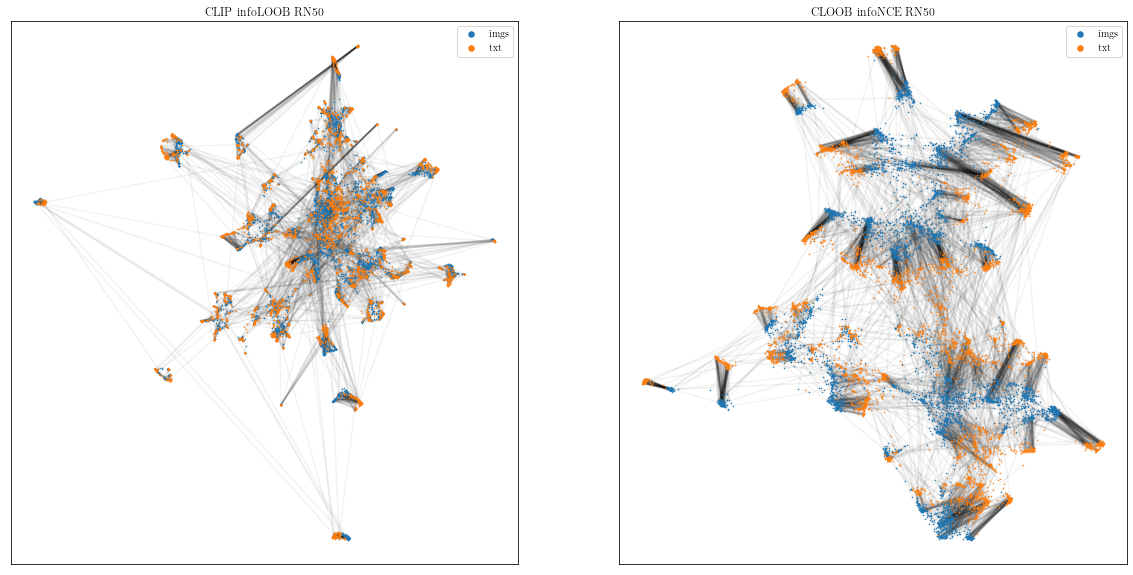

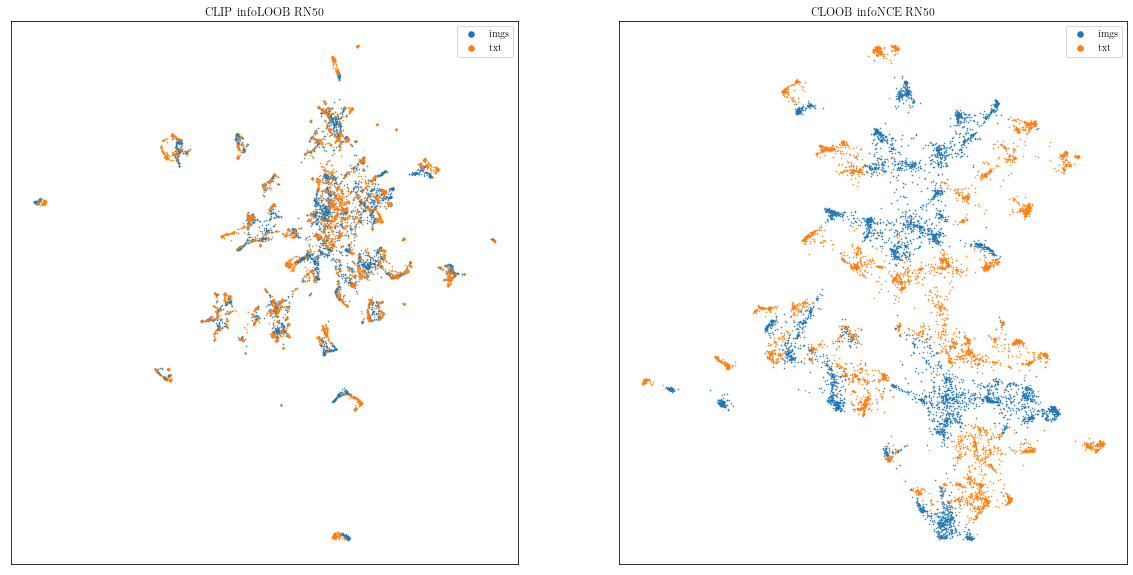

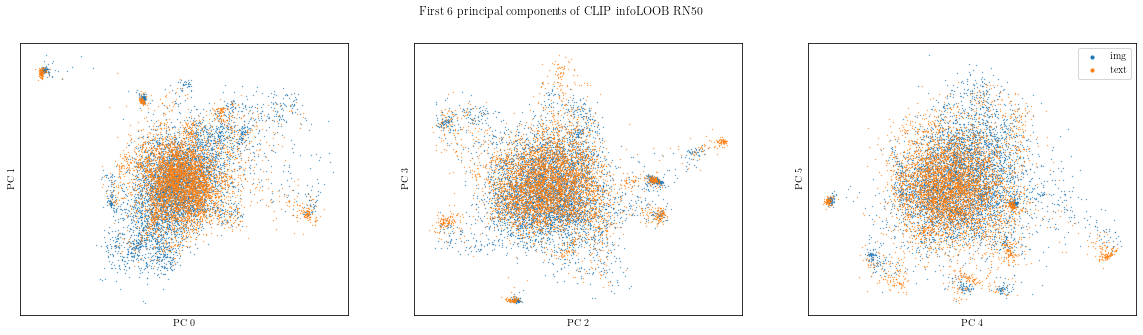

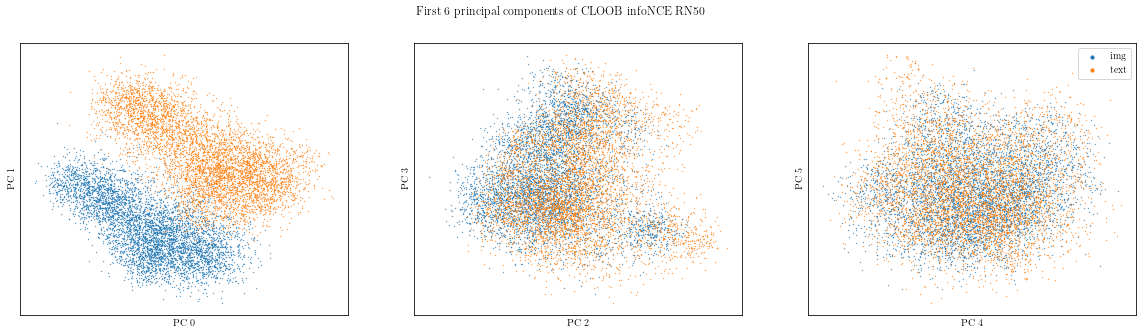

In [11]:

plot_comparisons([['CLIP infoLOOB RN50', 'ml_jku_clip_infoLOOB'],
                  ['CLOOB infoNCE RN50', 'ml_jku_cloob_infoNCE']])

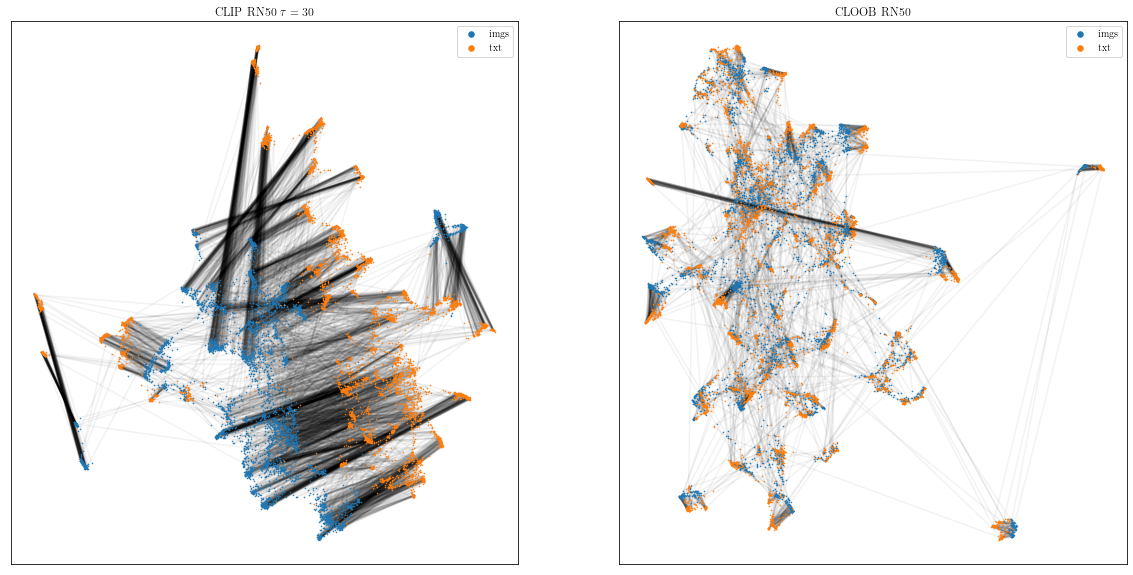

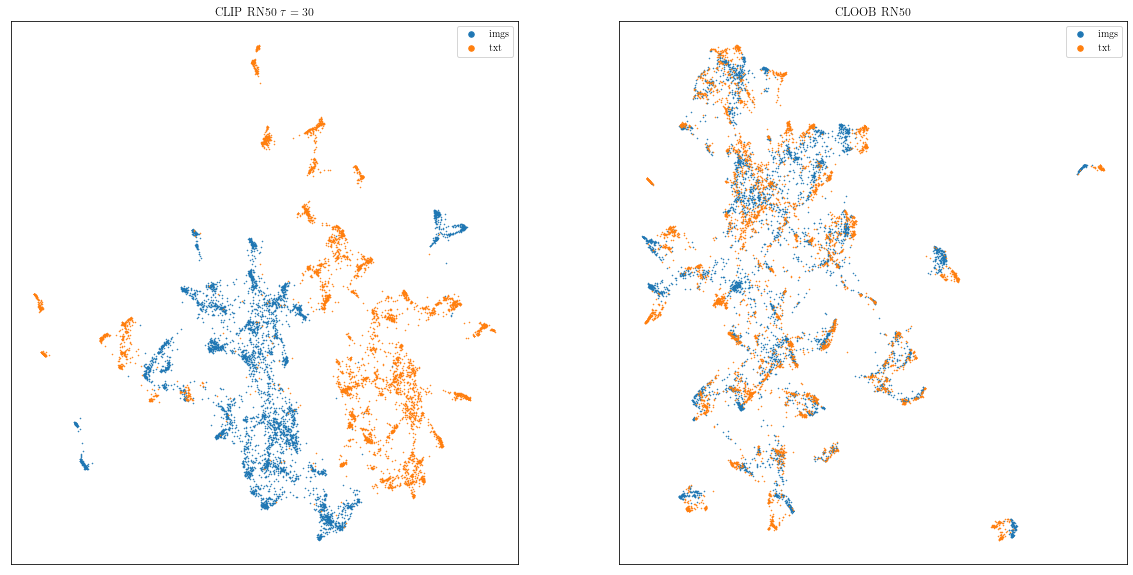

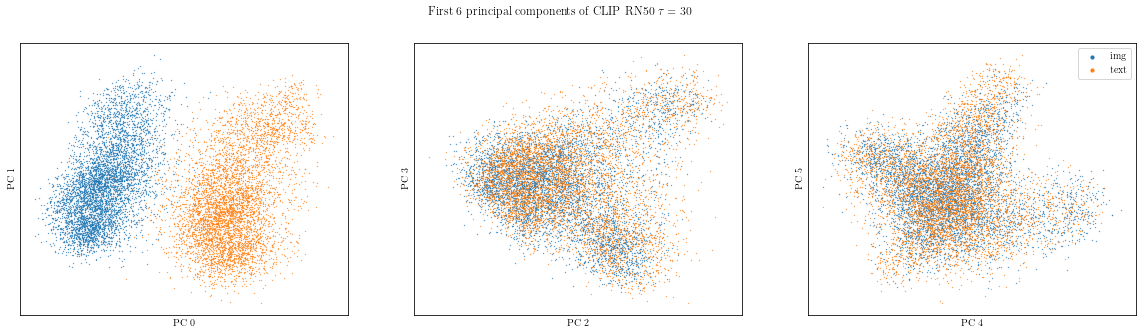

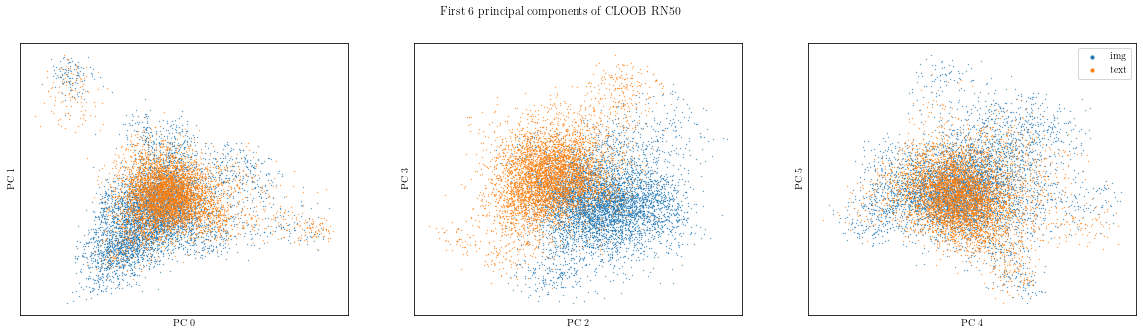

In [12]:
plot_comparisons([[r'CLIP RN50 $\tau=30$', 'ml_jku_clip_rn50'],
                            ['CLOOB RN50', 'ml_jku_cloob_rn50']])


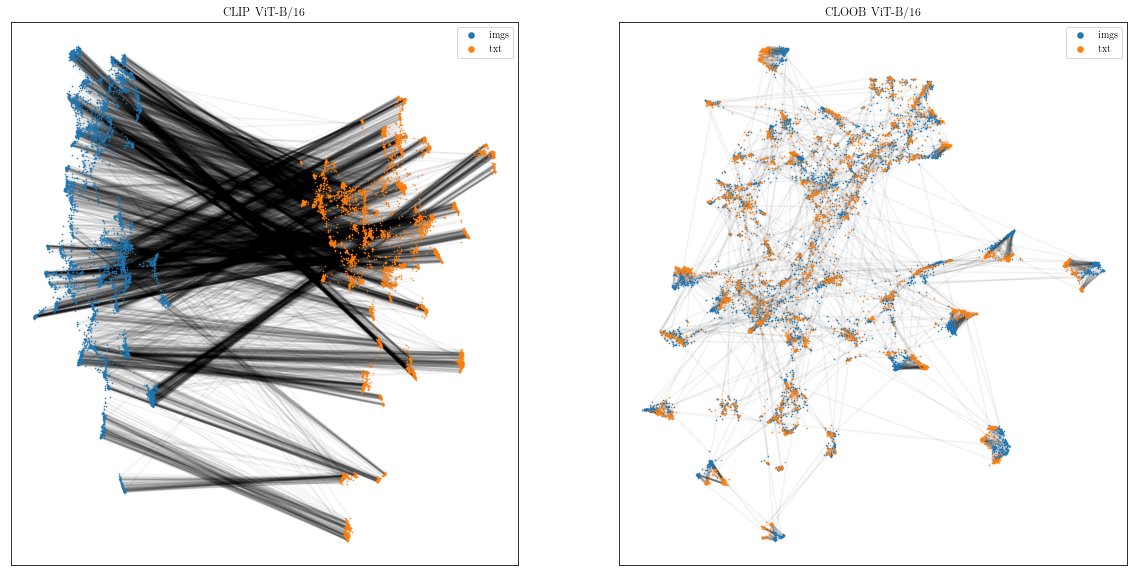

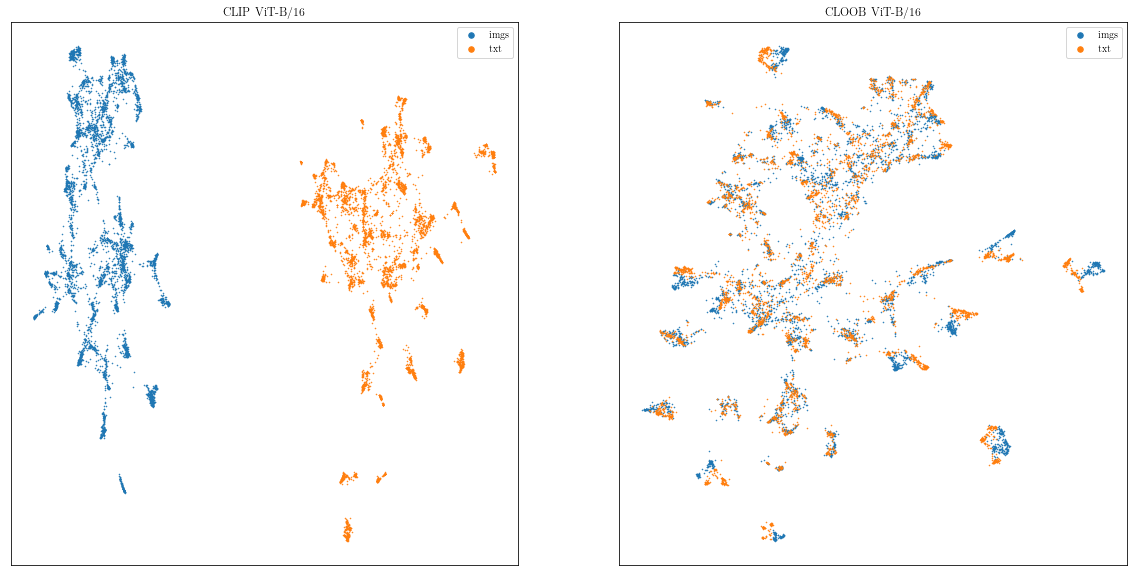

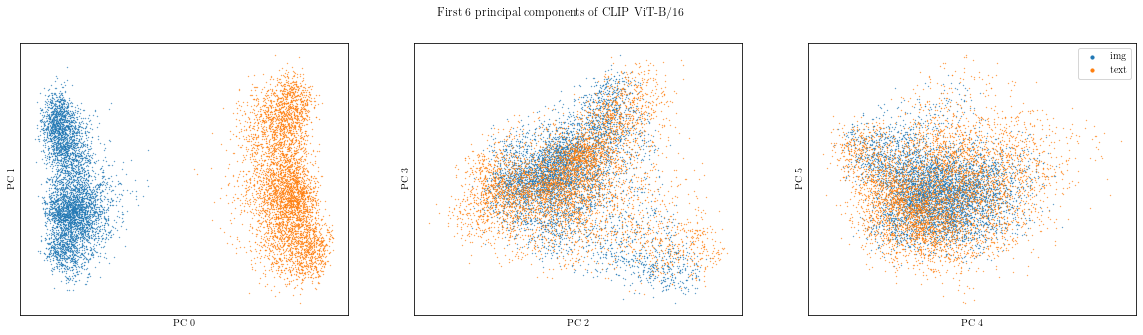

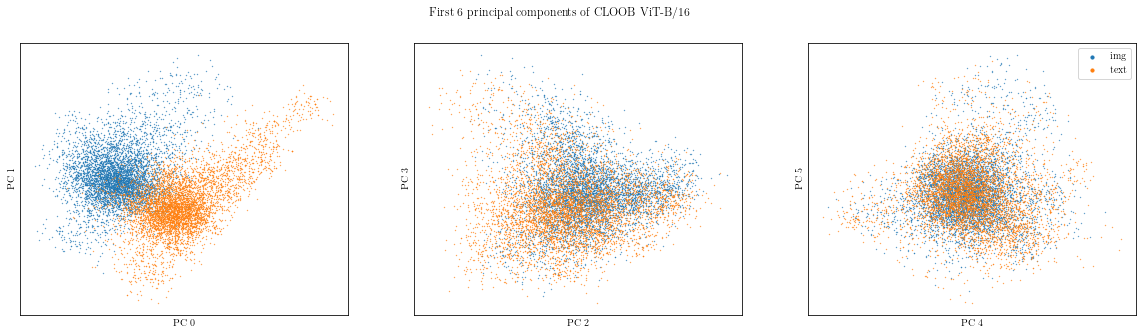

In [13]:
plot_comparisons([['CLIP ViT-B/16', 'openclip ViT-B-16'],
                  ['CLOOB ViT-B/16', 'cloob ViT-B-16']])

In [18]:
def plot_small_multiples(name, key):

    fig, axes = plt.subplots(4, 4, figsize=(20, 20), facecolor="white")
    for i, (min_dist, col) in enumerate(zip([0.0, 0.1, 0.4, 0.8], axes)):
        for j, (n_neighbors, ax) in enumerate(zip([5, 15, 50, 100], col)):
            umap = cached_umap(key, n=5000, k=n_neighbors, min_dist=min_dist)
            ax.scatter(umap.embedding_[:5000, 0], umap.embedding_[:5000, 1], label="img", s=0.3)
            ax.scatter(umap.embedding_[5000:, 0], umap.embedding_[5000:, 1], label="text", s=0.3)
            ax.set(title=f"min_dist={min_dist}, n_neighbors={n_neighbors}")

    ax.legend(markerscale=10)
    plt.gcf().suptitle(name, y=0.9)
    plt.savefig(f"figures/UMAP_ablations_{key}.png")

In [ ]:
plot_small_multiples("CLIP ViT-B/16", "openclip ViT-B-16")

In [ ]:
plot_small_multiples("CLOOB ViT-B/16", "cloob ViT-B-16")

openclip ViT-B-16


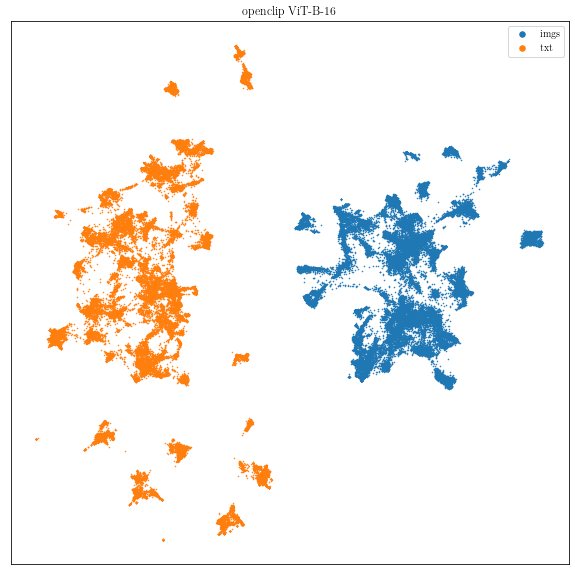

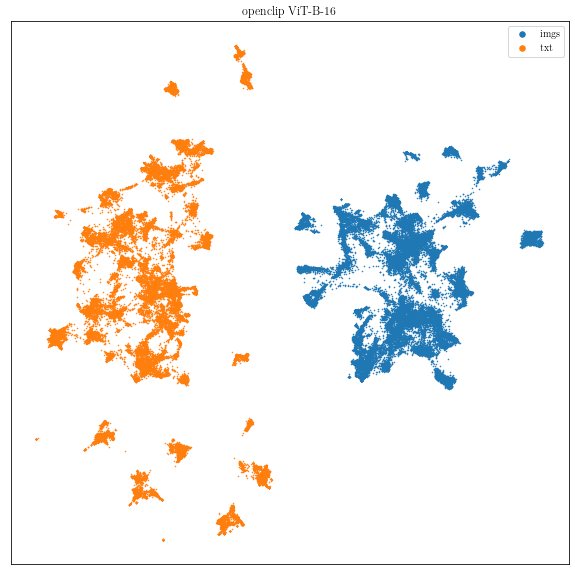

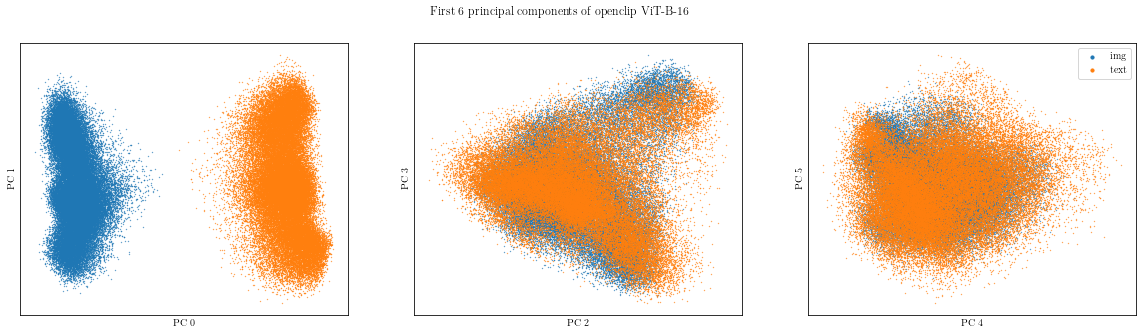

cloob ViT-B-16


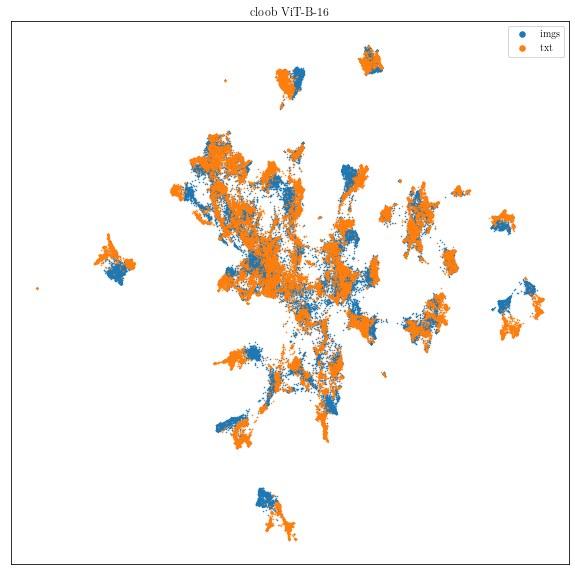

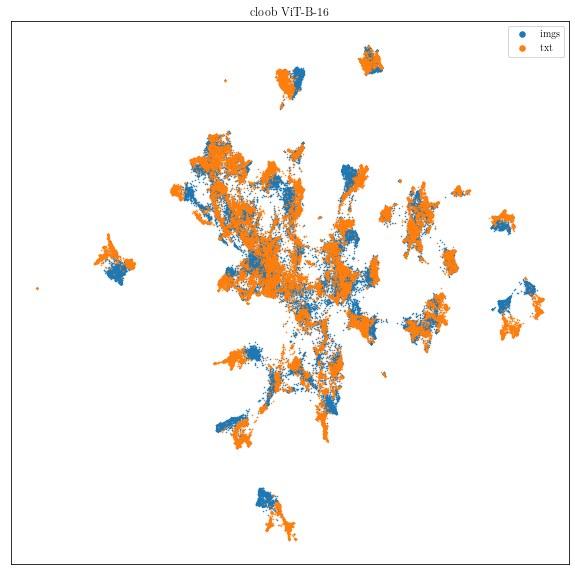

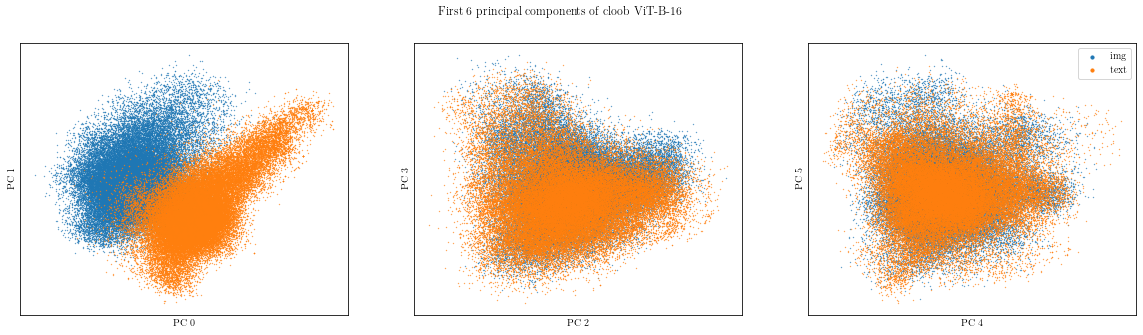

ml_jku_cloob_infoNCE


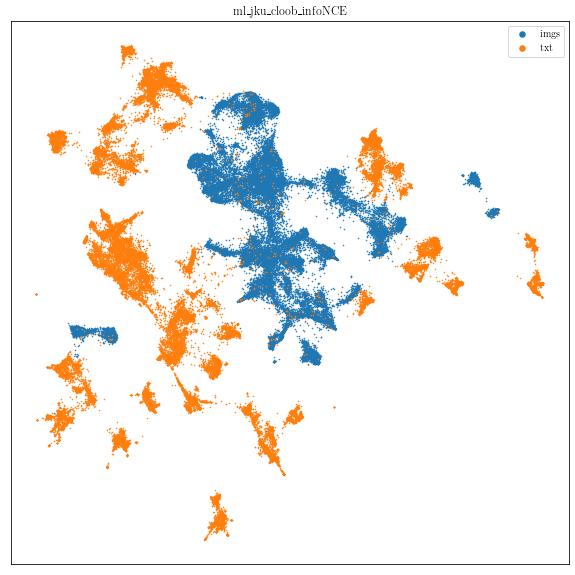

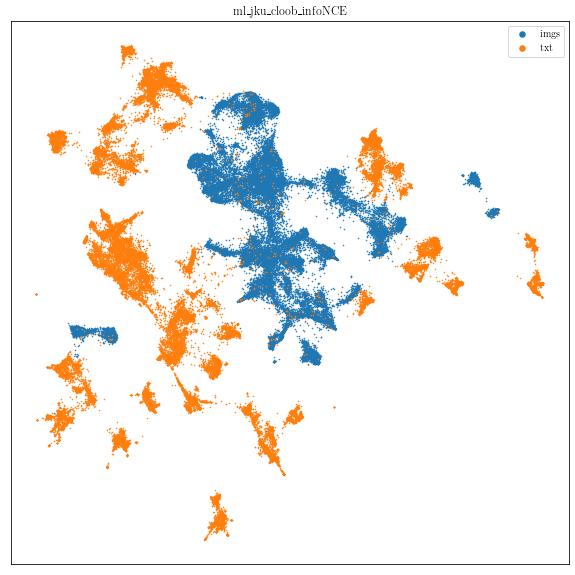

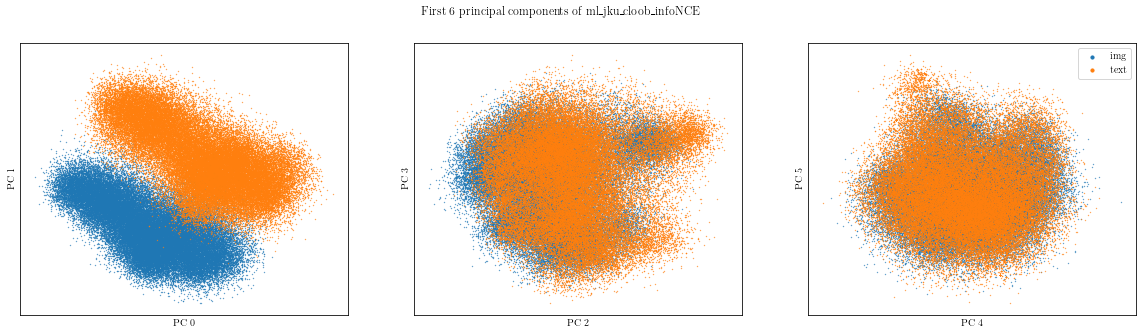

ml_jku_clip_rn50


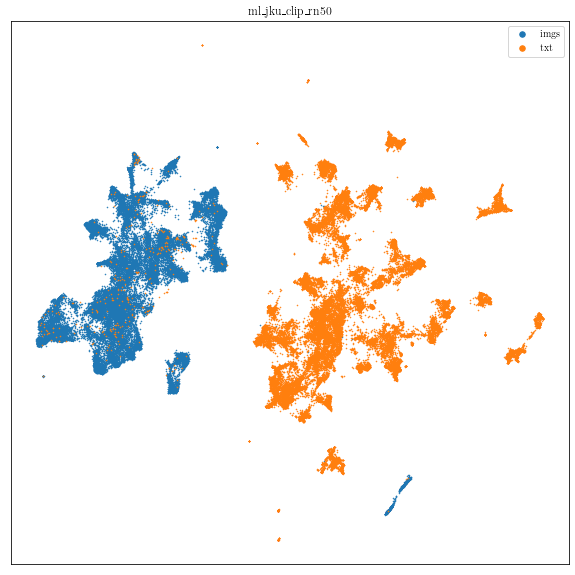

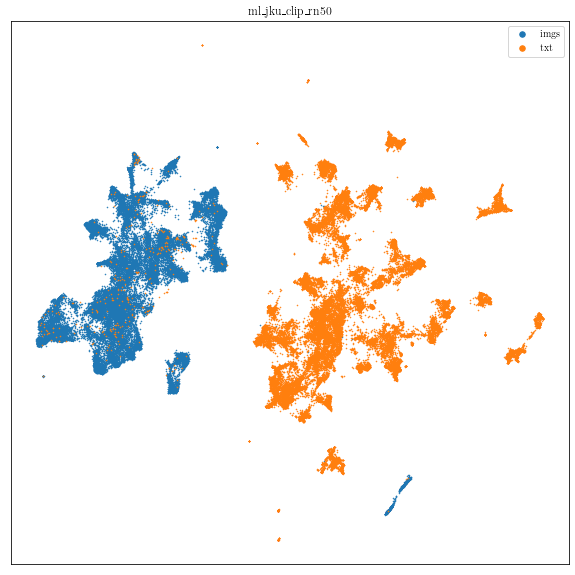

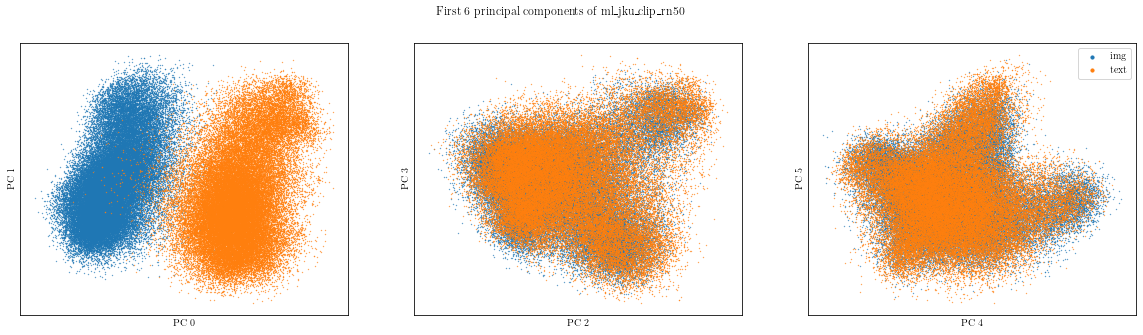

ml_jku_clip_infoLOOB


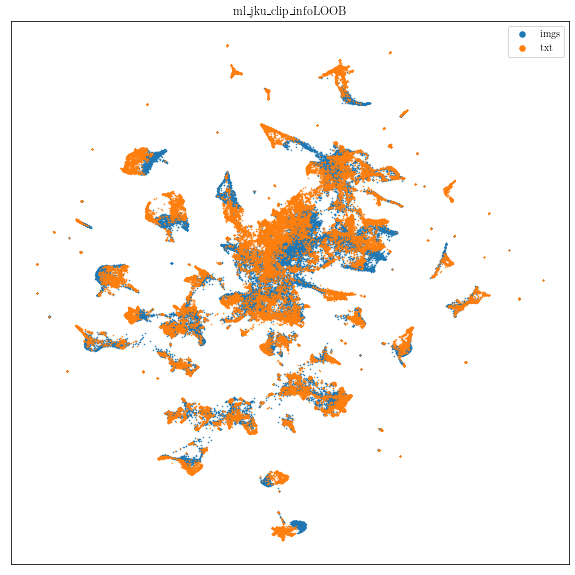

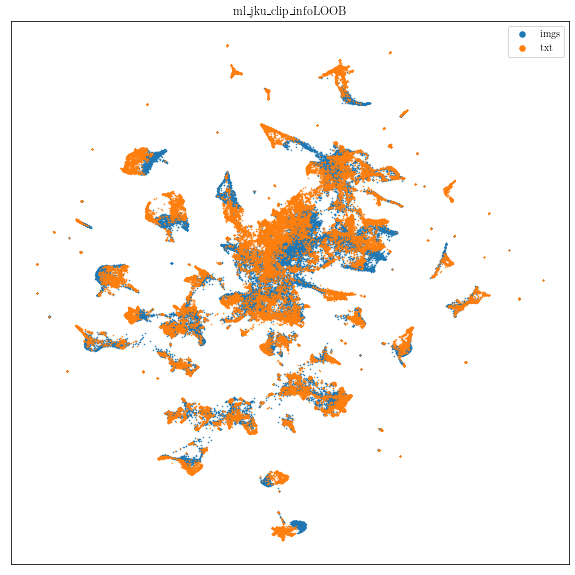

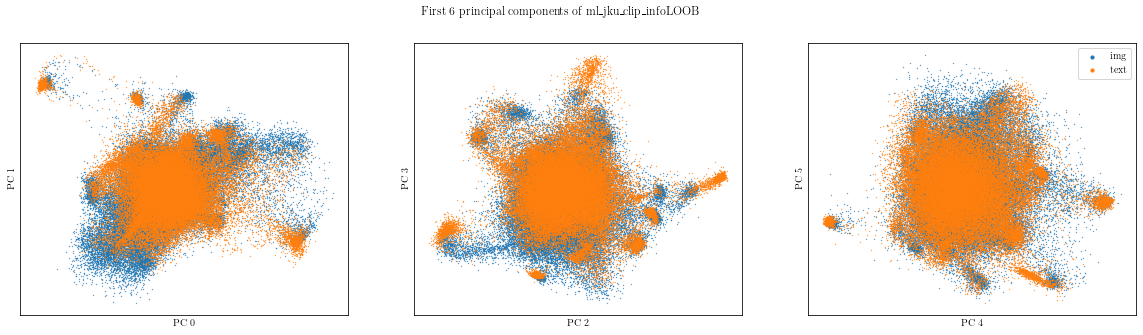

ml_jku_cloob_rn50


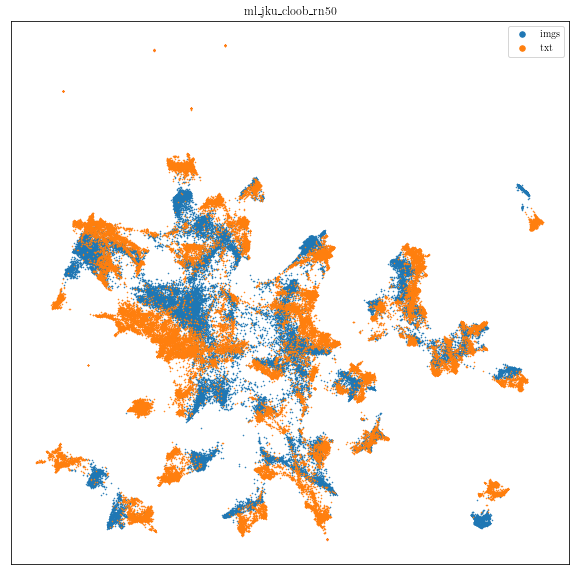

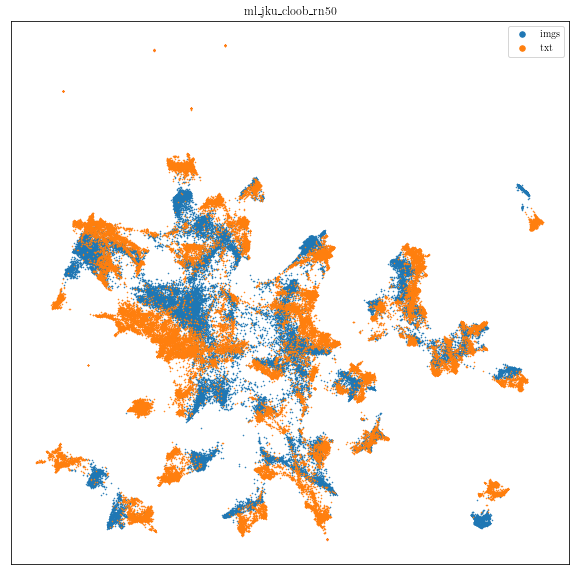

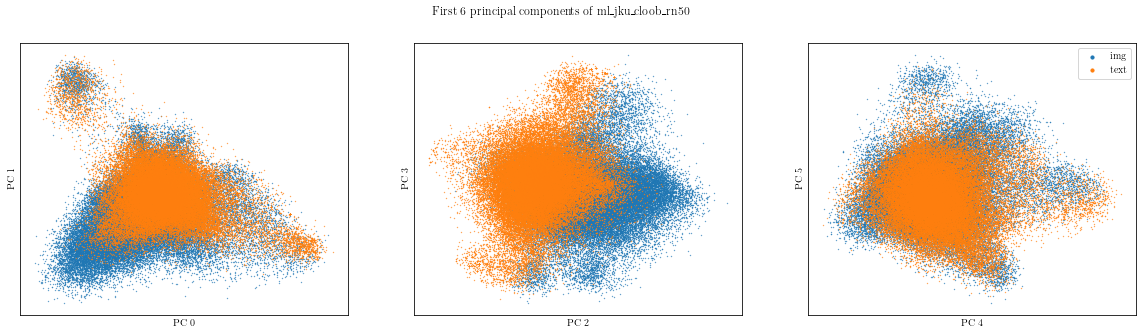

In [24]:
for name, embeds in models.items():
    print(name)
    plot_comparisons([[name, name]], n=50000)